In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
tf.set_random_seed(55)
np.random.seed(55)

In [2]:
class FNN(object):
    """Build a general FeedForward neural network
    Parameters
    ----------
    learning_rate: float
    drop_out: float
    Layers: list
    N_hidden: list
    D_input: int
    D_label: int
    Task_type: string
        'regression' or 'classification'
    L2_lambda: float
    """
    def __init__(self, learning_rate, drop_keep, Layers, N_hidden,
                 D_input, D_label, Task_type='regression', L2_lambda=0.0):
        #var
        self.learning_rate = learning_rate
        self.drop_keep = drop_keep
        self.Layers = Layers
        self.N_hidden = N_hidden
        self.D_input = D_input
        self.D_label = D_label
        #类型控制loss函数的选择
        self.Task_type = Task_type
        #L2 regularization的惩罚强弱，过高会使输出倾向于0
        self.L2_lambda = L2_lambda
        #用于存放锁累积的每层L2 regularization
        self.l2_penalty = tf.constant(0.0)
        
        #用于生成缩放图，括号里起名字
        with tf.name_scope('Input'):
            self.inputs = tf.placeholder(tf.float32,[None,D_input],name='inputs')
        with tf.name_scope('Label'):
            self.labels = tf.placeholder(tf.float32,[None,D_label],name='labels')
        with tf.name_scope('keep_rate'):
            self.drop_keep_rate = tf.placeholder(tf.float32,name='dropout_keep')
        
        #初始化时直接生成，build方法是后面会建立的
        self.build('F')
        
    def weight_init(self,shape):
        #shape: list [in_dim, out_dim]
        #can change initialization here
        initial = tf.random_uniform(shape,minval=-np.sqrt(5)*np.sqrt(1.0/shape[0]),maxval=np.sqrt(5)*np.sqrt(1.0/shape[0]))
        return tf.Variable(initial)
    
    def bias_init(self, shape):
        #can change initialization here
        initial = tf.constant(0.1,shape=shape)
        return tf.Variable(initial)
    
    def variable_summaries(self, var, name):
        with tf.name_scope(name+'_summaries'):
            mean = tf.reduce_mean(var)
            tf.scalar_summary('mean/'+name, mean)
        with tf.name_scope(name+'_stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var-mean)))
        #record the change data after each training
        tf.scalar_summary('_stddev/'+name,stddev)
        tf.scalar_summary('_max/'+name,tf.reduce_max(var))
        tf.scalar_summary('_min/'+name,tf.reduce_min(var))
        tf.histogram_summary(name,var)
    
    def layer(self, in_tensor, in_dim, out_dim, layer_name, act=tf.nn.relu):
        with tf.name_scope(layer_name):
            with tf.name_scope(layer_name+'_weights'):
                # initial by function weight_init()
                weights = self.weight_init([in_dim, out_dim])
                # 存放每一个权重W
                self.W.append(weights)
                # 对权重进行统计
                self.variable_summaries(weights, layer_name+'/weights')
            with tf.name_scope(layer_name+'_biases'):
                biases = self.bias_init([out_dim])
                self.variable_summaries(biases, layer_name+'/biases')
            with tf.name_scope(layer_name+'_Wx_plus_b'):
                #calculate Wx+b
                pre_activate = tf.matmul(in_tensor, weights) + biases
                #记录直方图
                tf.histogram_summary(layer_name+'/pre_activations',pre_activate)
                
            #计算a(Wx+b)
            activations = act(pre_activate, name='activation')
            tf.histogram_summary(layer_name+'/activations',activations)
        #返回该层的输出以及权重W的l2
        return activations, tf.nn.l2_loss(weights)
    
    def drop_layer(self, in_tensor):
        #tf.scalar_summary('droupout_keep', self.drop_keep_rate)
        dropped = tf.nn.dropout(in_tensor, self.drop_keep_rate)
        return dropped
    
    def build(self, prefix):
        #build net
        #incoming 代表当前tensor的流动位置
        incoming = self.inputs
        #if no hidden layers
        if self.Layers != 0:
            layer_nodes = [self.D_input] + self.N_hidden
        else:
            layer_nodes = [self.D_input]
        #hid_layers用于存储所有隐藏层的输出
        self.hid_layers = []
        #W用于存储所有层的权重
        self.W = []
        self.b = []
        self.total_l2 = []
        self.drop = []
        #开始叠加隐藏层
        for l in range(self.Layers):
            #使用刚才编写的函数来建立层，并更新incoming的位置
            incoming, l2_loss = self.layer(incoming, layer_nodes[l],layer_nodes[l+1],prefix+'_hid_'+str(l+1),act=tf.nn.relu)
            #累计l2
            self.total_l2.append(l2_loss)
            #output some info to know what we have built in th net
            print('Add dense layer: relu with drop_keep: %s'% self.drop_keep) 
            print('   %sD--> %sD'%(layer_nodes[l],layer_nodes[l+1]))
            #save output of hid_layers
            self.hid_layers.append(incoming)
            #add dropout layer
            incoming = self.drop_layer(incoming)
            #save output after dropout
            self.drop.append(incoming)
        #输出层建立。 activation 函数要根据任务来变换
        #回归任务，下面用的是tf.identity,没有activation函数
        if self.Task_type == 'regression':
            out_act = tf.identity
        else:
            #分类任务使用softmax来拟合概率
            out_act = tf.nn.softmax
        self.output, l2_loss = self.layer(incoming,layer_nodes[-1],self.D_label,layer_name='output',act=out_act)
        self.total_l2.append(l2_loss)
        print('Add output layer: linear')
        print('   %sD --> %sD' % (layer_nodes[-1],self.D_label))
        
        #l2 loss 缩略图
        with tf.name_scope('total_l2'):
            for l2 in self.total_l2:
                self.l2_penalty += l2
            tf.scalar_summary('l2_penalty', self.l2_penalty)
        
        #不同任务的loss
            #若为回归，则loss是用于判断所有预测值和实际值差别的函数
        if self.Task_type == 'regression':
            with tf.name_scope('SSE'):
                self.loss = tf.reduce_mean((self.output-self.labels)**2)
                tf.scalar_summary('loss', self.loss)
        else:
            #若为分类，cross entropy的loss函数 交叉熵
            entropy = tf.nn.softmax_cross_entropy_with_logits(self.output,self.labels)
            with tf.name_scope('cross entropy'):
                self.loss = tf.reduce_mean(entropy)
                tf.scalar_summary('loss',self.loss)
            with tf.name_scope('accuracy'):
                correct_prediction = tf.equal(tf.argmax(self.output, 1), tf.argmax(self.labels, 1))
                self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
                tf.scalar_summary('accuracy', self.accuracy)
        #整合所有loss
        with tf.name_scope('total_loss'):
            self.total_loss = self.loss + self.l2_penalty*self.L2_lambda
            tf.scalar_summary('total_loss', self.total_loss)
        #train op
        with tf.name_scope('train'):
            self.train_step = tf.train.AdamOptimizer(self.learning_rate).minimize(self.total_loss)
            
    def shfflelists(self, lists):
        ri = np.random.permutation(len(lists[1]))
        out = []
        for l in lists:
            out.append(l[ri])
        return out

In [3]:
# prepare the training data
inputs = [[0,0],[0,1],[1,0],[1,1]]
outputs = [0,1,1,0]
X = np.array(inputs).reshape((4,1,2)).astype('int16')
Y = np.array(outputs).reshape((4,1,1)).astype('int16')

In [4]:
#build the net instant
ff = FNN(learning_rate=1e-3, drop_keep=1.0, Layers=1, N_hidden=[2], 
         D_input=2, D_label=1, Task_type='regression', L2_lambda=1e-2)


Add dense layer: relu with drop_keep: 1.0
   2D--> 2D
Add output layer: linear
   2D --> 1D


In [5]:
sess = tf.InteractiveSession()
tf.initialize_all_variables().run()
merged = tf.merge_all_summaries()
train_writer = tf.train.SummaryWriter('log'+'/train',sess.graph)

In [6]:
# W before train

W0 = sess.run(ff.W[0])
W1 = sess.run(ff.W[1])
print('W_0:\n%s'%W0)
print('W_1:\n%s'%W1)

W_0:
[[-0.11052012  0.33037376]
 [ 0.35867608  1.47092748]]
W_1:
[[-1.01134253]
 [ 0.76089478]]


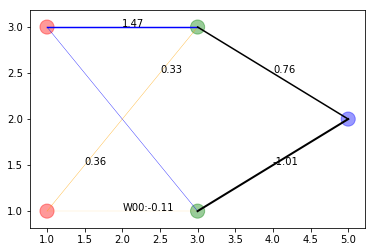

In [7]:
plt.scatter([1,1,5],[1,3,2],color=['red','red','blue'], s=200,alpha=0.4,marker='o')
plt.scatter([3,3],[1,3],color=['green','green'],s=200,alpha=0.4,marker='o')

plt.plot([1,3],[1,1],color='orange',linewidth=abs(W0[0,0]))
plt.annotate('W00:%0.2f' %W0[0,0],xy=(2, 1.0))

plt.plot([1,3],[3,1],color='blue',linewidth=abs(W0[1,0]))
plt.annotate('%0.2f' %W0[1,0],xy=(1.5, 1.5))

plt.plot([1,3],[1,3],color='orange',linewidth=abs(W0[0,1]))
plt.annotate('%0.2f' %W0[0,1],xy=(2.5,2.5))

plt.plot([1,3],[3,3],color='blue',linewidth=abs(W0[1,1]))
plt.annotate('%0.2f' %W0[1,1],xy=(2, 3))

plt.plot([3,5],[1,2],color='black',linewidth=abs(2*W1[0]))
plt.annotate('%0.2f' %W1[0],xy=(4, 1.5))

plt.plot([3,5],[3,2],color='black',linewidth=abs(2*W1[1]))
plt.annotate('%0.2f' %W1[1],xy=(4, 2.5))

[[ 0.07495522]
 [ 0.83143187]
 [ 0.42746913]
 [ 1.19458532]]


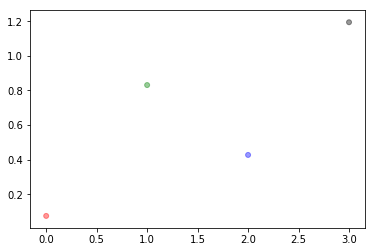

In [8]:
#output before training
pY = sess.run(ff.output, feed_dict={ff.inputs:X.reshape((4,2)), ff.drop_keep_rate:1.0})
print(pY)
plt.scatter([0,1,2,3],pY,color=['red','green','blue','black'],s=25,alpha=0.4,marker='o')

[[ 0.1         0.1       ]
 [ 0.45867607  1.5709275 ]
 [ 0.          0.43037376]
 [ 0.34815595  1.90130126]]


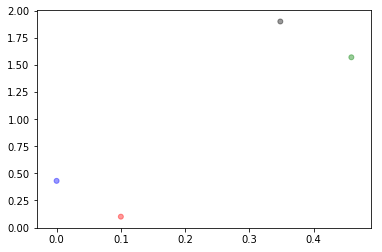

In [9]:
#hid_layer's output before training
pY = sess.run(ff.hid_layers[0], feed_dict={ff.inputs:X.reshape((4,2)),
                                           ff.drop_keep_rate:1.0})
print(pY)
plt.scatter(pY[:,0],pY[:,1],color=['red','green','blue','black'],s=25,alpha=0.4,marker='o')

In [10]:
sess.run(ff.drop[0],feed_dict={ff.inputs:X.reshape((4,2)),ff.labels:Y.reshape((4,1)),ff.drop_keep_rate:0.5})


array([[ 0.2       ,  0.2       ],
       [ 0.91735214,  3.141855  ],
       [ 0.        ,  0.        ],
       [ 0.69631189,  3.80260253]], dtype=float32)

In [ ]:
ff.labels

In [11]:

# training
k = 0.0
for i in range(10000):
    k += 1
    summary, acc = sess.run([merged,ff.train_step],feed_dict={ff.inputs:X.reshape((4,2)),
                                                            ff.labels:Y.reshape((4,1)),ff.drop_keep_rate:1.0})
    train_writer.add_summary(summary, k)

In [13]:
# 训练后的权重

W0=sess.run(ff.W[0])
W1=sess.run(ff.W[1])
print('W_0:\n%s' %W0)
print('W_1:\n%s' %W1)

W_0:
[[ 1.13731897  0.79838574]
 [ 1.13765407  0.79827988]]
W_1:
[[-1.60919726]
 [ 1.12892354]]


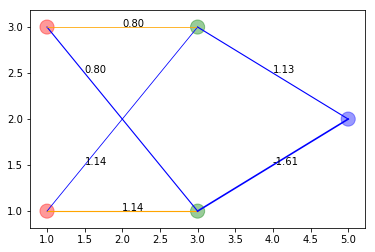

In [14]:
plt.scatter([1,1,5],[1,3,2],color=['red','red','blue'],s=200,alpha=0.4,marker='o')
plt.scatter([3,3],[1,3],color=['green','green'],s=200,alpha=0.4,marker='o')

plt.plot([1,3],[1,1],color='orange',linewidth=abs(W0[0,0]))
plt.annotate('%0.2f' %W0[0,0],xy=(2, 1.0))

plt.plot([1,3],[3,1],color='blue',linewidth=abs(W0[1,0]))
plt.annotate('%0.2f' %W0[1,0],xy=(1.5, 1.5))

plt.plot([1,3],[1,3],color='blue',linewidth=abs(W0[0,1]))
plt.annotate('%0.2f' %W0[0,1],xy=(1.5, 2.5))

plt.plot([1,3],[3,3],color='orange',linewidth=abs(W0[1,1]))
plt.annotate('%0.2f' %W0[1,1],xy=(2, 3))

plt.plot([3,5],[1,2],color='blue',linewidth=abs(W1[0]))
plt.annotate('%0.2f' %W1[0],xy=(4, 1.5))

plt.plot([3,5],[3,2],color='blue',linewidth=abs(W1[1]))
plt.annotate('%0.2f' %W1[1],xy=(4, 2.5))

[[ 0.0565991 ]
 [ 0.95770729]
 [ 0.9579156 ]
 [ 0.02885333]]


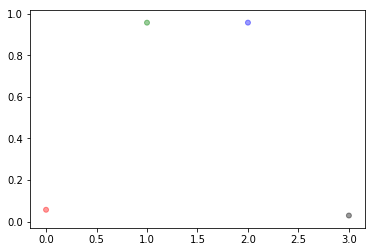

In [15]:
#output after training
pY = sess.run(ff.output, feed_dict={ff.inputs:X.reshape((4,2)),ff.drop_keep_rate:1.0})
print(pY)
plt.scatter([0,1,2,3],pY,color=['red','green','blue','black'],s=25,alpha=0.4,marker='o')

[[  0.00000000e+00   2.20810194e-02]
 [  5.51939011e-05   8.20360899e-01]
 [  0.00000000e+00   8.20466757e-01]
 [  1.13737404e+00   1.61874664e+00]]


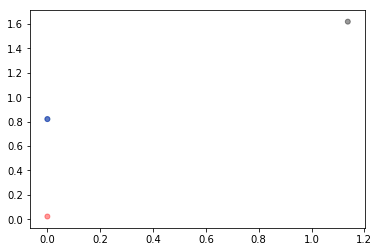

In [16]:
pY=sess.run(ff.hid_layers[0],feed_dict={ff.inputs:X.reshape((4,2)),ff.drop_keep_rate:1.0})

print(pY)
plt.scatter(pY[:,0],pY[:,1],color=['red','green','blue','black'],s=25,alpha=0.4,marker='o')

In [ ]:
# 该操作可以用于读取已经训练好的权重W和b
# 每层W想要读取的值
